# RTML | A3 Transformer Assignment

### Ulugbek Shernazarov - st125457

## Fine-tuning and Vision Transformer
This lab mainly focuses on the fine-tuning approach of vision transformer. During lab we defined our own custom vision transformer definition and compared it to the vision transformer provided by `torchvision.models.vit_b_16` model architecture. Then we trained the model for 7 epochs on custom sport dataset. As per analysis point, I have considered several optimizers, learning rates, applied early stopping concept, and fine-tuned the pretrained 7 epochs model for additional 100 epochs (mostly everything reached its terminating point by patience=5). I also utilized parallel gpu training on 4 GPUs (['NVIDIA GeForce RTX 2080 Ti', 'NVIDIA GeForce RTX 2080 Ti', 'NVIDIA GeForce RTX 2080 Ti', 'NVIDIA GeForce RTX 2080 Ti']) and the training process significantly was reduced. Below is task definition, and some preliminary results obtained during this lab session.

## TODO

1. Manage your available resources and continue fine-tune on the same dataset. The pretrained weights at 7th epoch (accuracy = 70%) is giving below link: (Hint: for batch_size = 8 on Puffer will used up 5GB of RAM in one GPU)

    https://drive.google.com/file/d/1Fewu2rhbqw99THDGPzDMPzgSu8J5iHfO/view?usp=sharing

    Feel free to download the file and continue fine-tuning with different settings. Make a challenge to achieve a better performance than my result (at 30th, I got 94%). There is no bound for the number of epochs to continue.

2. With your final fine-tuned weights, try to inference and get the result on images from "test" and "images to predict" directories in sport_dataset. Visualize some random inferenced images with their predictions.

3. Describe your experience on fine-tuning and show the graphs.



/tmp/ipykernel_1684908/3351360485.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.class_dict = {row[2]:row[0] for i, row in classes.iterrows()}
/tmp/ipykernel_1684908/3351360485.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.class_dict = {row[2]:row[0] for i, row in classes.iterrows()}


pole climbing,bowling,uneven bars,tennis,formula 1 racing,bungee jumping,log rolling,trapeze
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): Encode

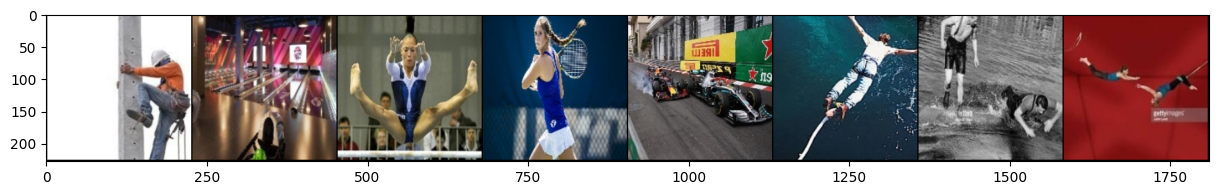

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import errno
import pandas as pd
import torchvision
import cv2
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16 as ViT, ViT_B_16_Weights
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt


# Multi-Head Self Attention (MSA)
class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super().__init__()
        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        self.d = d
        self.n_heads = n_heads
        self.d_head = d // n_heads

        self.q_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(n_heads)])

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        batch_size, seq_length, _ = sequences.shape
        result = []

        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q = self.q_mappings[head](sequence[:, head * self.d_head: (head + 1) * self.d_head])
                k = self.k_mappings[head](sequence[:, head * self.d_head: (head + 1) * self.d_head])
                v = self.v_mappings[head](sequence[:, head * self.d_head: (head + 1) * self.d_head])

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)

            result.append(torch.hstack(seq_result))

        return torch.stack(result)


# Positional Embeddings
def get_positional_embeddings(sequence_length, d, device="cpu"):
    pos_enc = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            pos_enc[i, j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return pos_enc.to(device)


# Vision Transformer (ViT)
# class ViT(nn.Module):
#     def __init__(self, input_shape, n_patches=7, hidden_d=8, n_heads=2, out_d=10):
#         super().__init__()
#         self.input_shape = input_shape
#         self.n_patches = n_patches
#         self.hidden_d = hidden_d
#         self.n_heads = n_heads

#         assert input_shape[1] % n_patches == 0 and input_shape[2] % n_patches == 0, "Input shape must be divisible by number of patches"

#         self.patch_size = (input_shape[1] // n_patches, input_shape[2] // n_patches)
#         self.input_d = input_shape[0] * self.patch_size[0] * self.patch_size[1]

#         self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
#         self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
#         self.ln1 = nn.LayerNorm((n_patches ** 2 + 1, hidden_d))
#         self.msa = MSA(hidden_d, n_heads)
#         self.ln2 = nn.LayerNorm((n_patches ** 2 + 1, hidden_d))
#         self.enc_mlp = nn.Sequential(nn.Linear(hidden_d, hidden_d), nn.ReLU())
#         self.mlp = nn.Sequential(nn.Linear(hidden_d, out_d), nn.Softmax(dim=-1))

#     def forward(self, images):
#         batch_size, _, _, _ = images.shape
#         patches = images.reshape(batch_size, self.n_patches ** 2, self.input_d)
#         tokens = self.linear_mapper(patches)

#         class_tokens = self.class_token.expand(batch_size, -1, -1)
#         tokens = torch.cat((class_tokens, tokens), dim=1)

#         pos_emb = get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d, device=tokens.device)
#         tokens += pos_emb.repeat(batch_size, 1, 1)

#         out = tokens + self.msa(self.ln1(tokens))
#         out = out + self.enc_mlp(self.ln2(out))

#         return self.mlp(out[:, 0])


class SportDataset(Dataset):
    """Sport dataset."""

    def __init__(self, csv_file, root_dir, class_file, train=True, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            class_file (string): Path to the csv file with class names and indices.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        classes = pd.read_csv(class_file)
        self.class_dict = {row[2]:row[0] for i, row in classes.iterrows()}

        df = pd.read_csv(csv_file)
        df.drop(index=5621, inplace=True)
        
        if train:
            self.df = df[df['data set'] == 'train']
        else:
            self.df = df[df['data set'] == 'valid']

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 1])
        image = io.imread(img_name)

        if image.shape[-1] != 3:
            image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

        if self.transform:
            image = self.transform(image)

        label_keys = self.df.iloc[idx, 2]
        labels = self.class_dict[label_keys]
        labels = float(labels)

        sample = {'image': image, 'labels': labels}

        return sample

# Logger for TensorBoard
class Logger:
    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name
        self.writer = SummaryWriter(comment=f"{model_name}_{data_name}")

    def log_loss(self, train_loss, val_loss, epoch):
        self.writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    def log_accuracy(self, train_acc, val_acc, epoch):
        self.writer.add_scalars("Accuracy", {"Train": train_acc, "Validation": val_acc}, epoch)

    def save_model(self, model, epoch):
        os.makedirs(f"saved/{self.model_name}", exist_ok=True)
        torch.save(model.state_dict(), f"saved/{self.model_name}/epoch_{epoch}.pth")

    def close(self):
        self.writer.close()


# Data Processing
train_transform = transforms.Compose([
    transforms.ToPILImage(mode="RGB"),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(mode="RGB"),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

csv_file = "../data/sports.csv"
class_file = "../data/sports.csv"
root_dir = "../data/"

train_ds = SportDataset(csv_file, root_dir, class_file, train=True, transform=train_transform)
val_ds = SportDataset(csv_file, root_dir, class_file, train=False, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

# Helper function to display images
def show_images(images, labels, class_dict):
    plt.rcParams["figure.figsize"] = [15, 5]
    img_grid = torchvision.utils.make_grid(images)
    npimg = img_grid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    print(",".join([class_dict[label.item()] for label in labels]))


# Display a batch of images
dataiter = iter(train_loader)
batch = next(dataiter)
show_images(batch["image"], batch["labels"], pd.read_csv(class_file).set_index("class id")["labels"].to_dict())

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# model = ViT((1, 28, 28), n_patches=7, hidden_d=20, n_heads=2, out_d=10)
# model = model.to(device)


model = ViT(weights=ViT_B_16_Weights.DEFAULT)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"{total_params/1000000}M")

model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=100, bias=True))

# Set the GPU Device
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to Device
model.to(device)
print("Classifier Head: ", model.heads)
# Initiate the weights and biases
for m in model.heads:
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.normal_(m.bias, std=1e-6)


In [3]:
# finetune.py
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
from torchvision.models import vit_b_16 as ViT, ViT_B_16_Weights
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

# Initialize Logger
class Logger:
    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name
        self.writer = SummaryWriter(comment=f"{model_name}_{data_name}")

    def log_loss(self, train_loss, val_loss, epoch):
        self.writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    def log_accuracy(self, train_acc, val_acc, epoch):
        self.writer.add_scalars("Accuracy", {"Train": train_acc, "Validation": val_acc}, epoch)

    def save_model(self, model, epoch, model_descr, val_acc):
        os.makedirs(f"saved/{self.model_name}", exist_ok=True)
        torch.save(model.state_dict(), f"saved/{self.model_name}/{model_descr}_epoch_{epoch}.pth")
        print(f"✅ New Best Model Saved at saved/{self.model_name}/{model_descr}_epoch_{epoch}.pth (Accuracy: {val_acc:.4%})")
        

    def close(self):
        self.writer.close()

# Experiment configurations
experiment_configs = [
    # {"lr": 5e-6, "optimizer": "Adam", "batch_size": 256},
    # {"lr": 1e-5, "optimizer": "SGD", "batch_size": 256},
    {"lr": 3e-6, "optimizer": "AdamW", "batch_size": 256},
]

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Best accuracy tracker
best_accuracy = 0.5
best_vloss = float('inf')
patience = 5

logger = Logger(model_name="ViT_Finetune", data_name="SportsDataset")

# Fine-Tuning Loop
for config in experiment_configs:
    # Initialize device, first we will move pretrained weights, then move our model to several gpus
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the ViT model
    model = ViT(weights=ViT_B_16_Weights.DEFAULT)
    
    # Modify classifier head
    model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=100, bias=True))
    
    # Load checkpoint (7th epoch)
    file_name = 'Ep.7.pth'
    if os.path.exists(file_name):
        print(f"Loading checkpoint: {file_name}")
        state = torch.load(file_name, map_location=device)
        model.load_state_dict(state)
    
    # Lets move model to several gpus
    # Detect available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Using {num_gpus} GPU(s): {[torch.cuda.get_device_name(i) for i in range(num_gpus)]}")
        
    # Move model to multiple GPUs
    if num_gpus > 1:
        model = nn.DataParallel(model)  # Enable multi-GPU training
    model.to(device)
    print(f"\n🔍 Starting Fine-Tuning with {config}\n")

    # Choose optimizer
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)
    elif config["optimizer"] == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
    else:
        raise ValueError(f"Unsupported optimizer: {config['optimizer']}")

    # Update DataLoader with multi-GPU friendly batch size
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True, num_workers=num_gpus)
    val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False, num_workers=num_gpus)

    additional_epochs = 100
    best_model_path = f"best_finetuned_{config['optimizer']}_lr{config['lr']}"
    epochs_without_improvement = 0

    for epoch in range(1, additional_epochs + 1):
        print(f"\n🚀 Fine-Tuning EPOCH {epoch}/{additional_epochs} | LR: {config['lr']}, Optimizer: {config['optimizer']}")

        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for data in tqdm(train_loader, desc='Training'):
            inputs, labels = data['image'].to(device), data['labels'].long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4%}")

        # Validation Phase
        model.eval()
        running_vloss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for data in tqdm(val_loader, desc="Validation"):
                inputs, labels = data['image'].to(device), data['labels'].long().to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                running_vloss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_vloss = running_vloss / len(val_loader)
        val_acc = correct_val / total_val
        print(f"Valid Loss: {avg_vloss:.4f}, Valid Accuracy: {val_acc:.4%}")

        # Log statistics
        logger.log_loss(avg_train_loss, avg_vloss, epoch)
        logger.log_accuracy(train_acc, val_acc, epoch)

        # Check for best accuracy improvement
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            logger.save_model(model, epoch, best_model_path, val_acc)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"⏹ Early stopping triggered. No improvement in last {patience} epochs.")
            break

    print(f"\n🏆 Finished Fine-Tuning for {config}. Best Accuracy: {best_accuracy:.4%}")

# Close logger
logger.close()


Loading checkpoint: Ep.7.pth
Using 4 GPU(s): ['NVIDIA GeForce RTX 2080 Ti', 'NVIDIA GeForce RTX 2080 Ti', 'NVIDIA GeForce RTX 2080 Ti', 'NVIDIA GeForce RTX 2080 Ti']

🔍 Starting Fine-Tuning with {'lr': 3e-06, 'optimizer': 'AdamW', 'batch_size': 256}


🚀 Fine-Tuning EPOCH 1/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:55<00:00,  1.05s/it]


Train Loss: 0.8855, Train Accuracy: 84.4204%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid Loss: 0.8221, Valid Accuracy: 84.2000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_1.pth (Accuracy: 84.2000%)

🚀 Fine-Tuning EPOCH 2/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:58<00:00,  1.10s/it]


Train Loss: 0.7416, Train Accuracy: 87.7186%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid Loss: 0.7094, Valid Accuracy: 86.0000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_2.pth (Accuracy: 86.0000%)

🚀 Fine-Tuning EPOCH 3/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:58<00:00,  1.11s/it]


Train Loss: 0.6360, Train Accuracy: 89.8014%


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid Loss: 0.6296, Valid Accuracy: 88.2000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_3.pth (Accuracy: 88.2000%)

🚀 Fine-Tuning EPOCH 4/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.13s/it]


Train Loss: 0.5474, Train Accuracy: 91.4468%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Valid Loss: 0.5549, Valid Accuracy: 90.4000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_4.pth (Accuracy: 90.4000%)

🚀 Fine-Tuning EPOCH 5/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.4762, Train Accuracy: 92.9366%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Valid Loss: 0.5066, Valid Accuracy: 90.4000%

🚀 Fine-Tuning EPOCH 6/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.4189, Train Accuracy: 93.9297%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid Loss: 0.4544, Valid Accuracy: 90.8000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_6.pth (Accuracy: 90.8000%)

🚀 Fine-Tuning EPOCH 7/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.3682, Train Accuracy: 94.9822%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid Loss: 0.4185, Valid Accuracy: 91.6000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_7.pth (Accuracy: 91.6000%)

🚀 Fine-Tuning EPOCH 8/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.3248, Train Accuracy: 95.8123%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid Loss: 0.3838, Valid Accuracy: 92.8000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_8.pth (Accuracy: 92.8000%)

🚀 Fine-Tuning EPOCH 9/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.2878, Train Accuracy: 96.5165%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Valid Loss: 0.3596, Valid Accuracy: 93.6000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_9.pth (Accuracy: 93.6000%)

🚀 Fine-Tuning EPOCH 10/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.2561, Train Accuracy: 97.1020%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid Loss: 0.3349, Valid Accuracy: 94.2000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_10.pth (Accuracy: 94.2000%)

🚀 Fine-Tuning EPOCH 11/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.2274, Train Accuracy: 97.7023%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid Loss: 0.3138, Valid Accuracy: 93.0000%

🚀 Fine-Tuning EPOCH 12/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.2039, Train Accuracy: 98.1989%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid Loss: 0.3017, Valid Accuracy: 94.0000%

🚀 Fine-Tuning EPOCH 13/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.1840, Train Accuracy: 98.3694%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Valid Loss: 0.2822, Valid Accuracy: 94.6000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_13.pth (Accuracy: 94.6000%)

🚀 Fine-Tuning EPOCH 14/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.1652, Train Accuracy: 98.7252%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid Loss: 0.2693, Valid Accuracy: 95.0000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_14.pth (Accuracy: 95.0000%)

🚀 Fine-Tuning EPOCH 15/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.11s/it]


Train Loss: 0.1478, Train Accuracy: 98.9698%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Valid Loss: 0.2549, Valid Accuracy: 95.8000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_15.pth (Accuracy: 95.8000%)

🚀 Fine-Tuning EPOCH 16/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.1336, Train Accuracy: 99.1699%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Valid Loss: 0.2463, Valid Accuracy: 95.0000%

🚀 Fine-Tuning EPOCH 17/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.1204, Train Accuracy: 99.3107%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Valid Loss: 0.2398, Valid Accuracy: 95.4000%

🚀 Fine-Tuning EPOCH 18/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.1087, Train Accuracy: 99.4664%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid Loss: 0.2281, Valid Accuracy: 95.8000%

🚀 Fine-Tuning EPOCH 19/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.0990, Train Accuracy: 99.5627%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Valid Loss: 0.2234, Valid Accuracy: 95.6000%

🚀 Fine-Tuning EPOCH 20/100 | LR: 3e-06, Optimizer: AdamW


Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Train Loss: 0.0888, Train Accuracy: 99.6591%


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

Valid Loss: 0.2147, Valid Accuracy: 95.8000%
⏹ Early stopping triggered. No improvement in last 5 epochs.

🏆 Finished Fine-Tuning for {'lr': 3e-06, 'optimizer': 'AdamW', 'batch_size': 256}. Best Accuracy: 95.8000%


In [ ]:
# finetune.log
Loading checkpoint: Ep.7.pth
Using 4 GPU(s): ['NVIDIA GeForce RTX 2080 Ti', 'NVIDIA GeForce RTX 2080 Ti', 'NVIDIA GeForce RTX 2080 Ti', 'NVIDIA GeForce RTX 2080 Ti']

🔍 Starting Fine-Tuning with {'lr': 5e-06, 'optimizer': 'Adam', 'batch_size': 256}


🚀 Fine-Tuning EPOCH 1/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:58<00:00,  1.10s/it]
Train Loss: 0.8558, Train Accuracy: 84.6724%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]
Valid Loss: 0.7530, Valid Accuracy: 86.0000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_1.pth (Accuracy: 86.0000%)

🚀 Fine-Tuning EPOCH 2/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [01:00<00:00,  1.14s/it]
Train Loss: 0.6476, Train Accuracy: 89.2899%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]
Valid Loss: 0.6036, Valid Accuracy: 88.8000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_2.pth (Accuracy: 88.8000%)

🚀 Fine-Tuning EPOCH 3/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [01:00<00:00,  1.13s/it]
Train Loss: 0.5139, Train Accuracy: 91.7877%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]
Valid Loss: 0.5021, Valid Accuracy: 91.6000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_3.pth (Accuracy: 91.6000%)

🚀 Fine-Tuning EPOCH 4/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.4144, Train Accuracy: 93.9890%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
Valid Loss: 0.4410, Valid Accuracy: 92.2000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_4.pth (Accuracy: 92.2000%)

🚀 Fine-Tuning EPOCH 5/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.3391, Train Accuracy: 95.2564%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
Valid Loss: 0.3832, Valid Accuracy: 92.6000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_5.pth (Accuracy: 92.6000%)

🚀 Fine-Tuning EPOCH 6/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.2800, Train Accuracy: 96.5090%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]
Valid Loss: 0.3481, Valid Accuracy: 92.2000%

🚀 Fine-Tuning EPOCH 7/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.2316, Train Accuracy: 97.5245%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]
Valid Loss: 0.3041, Valid Accuracy: 94.4000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_7.pth (Accuracy: 94.4000%)

🚀 Fine-Tuning EPOCH 8/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.13s/it]
Train Loss: 0.1938, Train Accuracy: 98.1396%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]
Valid Loss: 0.2780, Valid Accuracy: 94.8000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_8.pth (Accuracy: 94.8000%)

🚀 Fine-Tuning EPOCH 9/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.11s/it]
Train Loss: 0.1627, Train Accuracy: 98.7252%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]
Valid Loss: 0.2558, Valid Accuracy: 96.4000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_9.pth (Accuracy: 96.4000%)

🚀 Fine-Tuning EPOCH 10/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:58<00:00,  1.11s/it]
Train Loss: 0.1373, Train Accuracy: 99.0439%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]
Valid Loss: 0.2376, Valid Accuracy: 96.0000%

🚀 Fine-Tuning EPOCH 11/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.1166, Train Accuracy: 99.3033%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]
Valid Loss: 0.2244, Valid Accuracy: 96.2000%

🚀 Fine-Tuning EPOCH 12/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.0994, Train Accuracy: 99.5108%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]
Valid Loss: 0.2139, Valid Accuracy: 95.0000%

🚀 Fine-Tuning EPOCH 13/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.0847, Train Accuracy: 99.6665%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]
Valid Loss: 0.2078, Valid Accuracy: 95.2000%

🚀 Fine-Tuning EPOCH 14/100 | LR: 5e-06, Optimizer: Adam
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.0739, Train Accuracy: 99.7554%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]
Valid Loss: 0.1959, Valid Accuracy: 96.2000%
⏹ Early stopping triggered. No improvement in last 5 epochs.

🏆 Finished Fine-Tuning for {'lr': 5e-06, 'optimizer': 'Adam', 'batch_size': 256}. Best Accuracy: 96.4000%

🔍 Starting Fine-Tuning with {'lr': 3e-06, 'optimizer': 'AdamW', 'batch_size': 256}


🚀 Fine-Tuning EPOCH 1/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:55<00:00,  1.05s/it]
Train Loss: 0.8855, Train Accuracy: 84.4204%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]
Valid Loss: 0.8221, Valid Accuracy: 84.2000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_1.pth (Accuracy: 84.2000%)

🚀 Fine-Tuning EPOCH 2/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:58<00:00,  1.10s/it]
Train Loss: 0.7416, Train Accuracy: 87.7186%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]
Valid Loss: 0.7094, Valid Accuracy: 86.0000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_2.pth (Accuracy: 86.0000%)

🚀 Fine-Tuning EPOCH 3/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:58<00:00,  1.11s/it]
Train Loss: 0.6360, Train Accuracy: 89.8014%
Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]
Valid Loss: 0.6296, Valid Accuracy: 88.2000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_3.pth (Accuracy: 88.2000%)

🚀 Fine-Tuning EPOCH 4/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.13s/it]
Train Loss: 0.5474, Train Accuracy: 91.4468%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
Valid Loss: 0.5549, Valid Accuracy: 90.4000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_4.pth (Accuracy: 90.4000%)

🚀 Fine-Tuning EPOCH 5/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.4762, Train Accuracy: 92.9366%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]
Valid Loss: 0.5066, Valid Accuracy: 90.4000%

🚀 Fine-Tuning EPOCH 6/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.4189, Train Accuracy: 93.9297%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]
Valid Loss: 0.4544, Valid Accuracy: 90.8000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_6.pth (Accuracy: 90.8000%)

🚀 Fine-Tuning EPOCH 7/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.3682, Train Accuracy: 94.9822%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]
Valid Loss: 0.4185, Valid Accuracy: 91.6000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_7.pth (Accuracy: 91.6000%)

🚀 Fine-Tuning EPOCH 8/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.3248, Train Accuracy: 95.8123%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]
Valid Loss: 0.3838, Valid Accuracy: 92.8000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_8.pth (Accuracy: 92.8000%)

🚀 Fine-Tuning EPOCH 9/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.2878, Train Accuracy: 96.5165%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]
Valid Loss: 0.3596, Valid Accuracy: 93.6000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_9.pth (Accuracy: 93.6000%)

🚀 Fine-Tuning EPOCH 10/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.2561, Train Accuracy: 97.1020%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]
Valid Loss: 0.3349, Valid Accuracy: 94.2000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_10.pth (Accuracy: 94.2000%)

🚀 Fine-Tuning EPOCH 11/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.2274, Train Accuracy: 97.7023%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]
Valid Loss: 0.3138, Valid Accuracy: 93.0000%

🚀 Fine-Tuning EPOCH 12/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.2039, Train Accuracy: 98.1989%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]
Valid Loss: 0.3017, Valid Accuracy: 94.0000%

🚀 Fine-Tuning EPOCH 13/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.1840, Train Accuracy: 98.3694%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
Valid Loss: 0.2822, Valid Accuracy: 94.6000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_13.pth (Accuracy: 94.6000%)

🚀 Fine-Tuning EPOCH 14/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.1652, Train Accuracy: 98.7252%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]
Valid Loss: 0.2693, Valid Accuracy: 95.0000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_14.pth (Accuracy: 95.0000%)

🚀 Fine-Tuning EPOCH 15/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.11s/it]
Train Loss: 0.1478, Train Accuracy: 98.9698%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
Valid Loss: 0.2549, Valid Accuracy: 95.8000%
✅ New Best Model Saved at saved/ViT_Finetune/best_finetuned_AdamW_lr3e-06_epoch_15.pth (Accuracy: 95.8000%)

🚀 Fine-Tuning EPOCH 16/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.1336, Train Accuracy: 99.1699%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]
Valid Loss: 0.2463, Valid Accuracy: 95.0000%

🚀 Fine-Tuning EPOCH 17/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.1204, Train Accuracy: 99.3107%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]
Valid Loss: 0.2398, Valid Accuracy: 95.4000%

🚀 Fine-Tuning EPOCH 18/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.1087, Train Accuracy: 99.4664%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]
Valid Loss: 0.2281, Valid Accuracy: 95.8000%

🚀 Fine-Tuning EPOCH 19/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.0990, Train Accuracy: 99.5627%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
Valid Loss: 0.2234, Valid Accuracy: 95.6000%

🚀 Fine-Tuning EPOCH 20/100 | LR: 3e-06, Optimizer: AdamW
Training: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]
Train Loss: 0.0888, Train Accuracy: 99.6591%
Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]
Valid Loss: 0.2147, Valid Accuracy: 95.8000%
⏹ Early stopping triggered. No improvement in last 5 epochs.

🏆 Finished Fine-Tuning for {'lr': 3e-06, 'optimizer': 'AdamW', 'batch_size': 256}. Best Accuracy: 95.8000%

Based on obtained result {'lr': 5e-06, 'optimizer': 'Adam', 'batch_size': 256}. Best Accuracy: 96.4000% performing the best

| Optimizer | Batch_size | Learning Rate | Fine-tuned Epochs | Best Accuracy on Validation Set |
|-----------|------------|---------------|-------------------|---------------------------------|
| Adam      |   256      | 5e-06         |  9                | 96.4%                           |
| SGD       |   256      | 1e-5          |  55               | 93.8%                           |
| AdamW      |   256      | 5e-06         |  20               | 95.8%                           |

Loading best fine-tuned model: saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_9.pth


/tmp/ipykernel_1684908/1718855201.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_dict = {row[0]: row[1] for _, row in class_df.iterrows()}


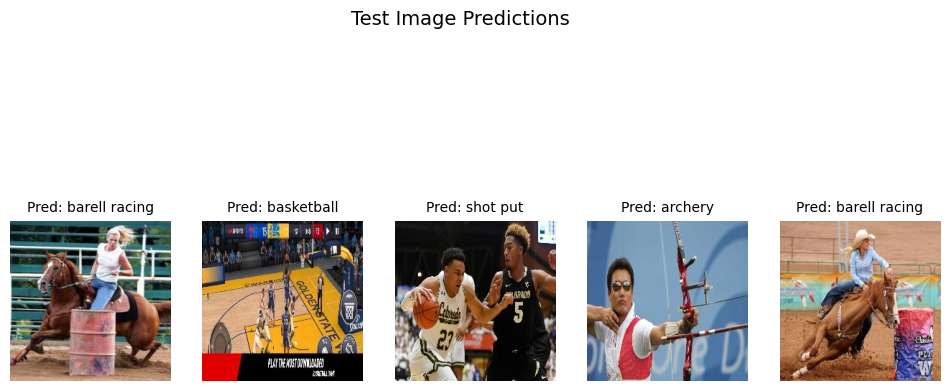

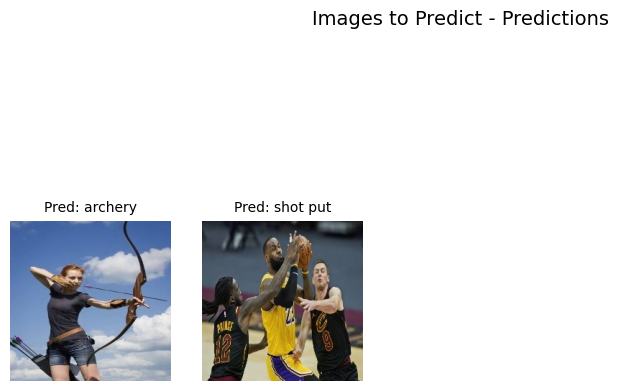

In [31]:
# inference.py
import torch
import torch.nn as nn
import os
import cv2
import random
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16 as ViT, ViT_B_16_Weights
from skimage import io

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load best fine-tuned model
best_model_path = "saved/ViT_Finetune/best_finetuned_Adam_lr5e-06_epoch_9.pth"  # Adjust based on the best-performing model
model = ViT(weights=ViT_B_16_Weights.DEFAULT)

# Modify classifier head
model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=100, bias=True))

# Move model to GPU(s)
num_gpus = torch.cuda.device_count()
if num_gpus > 1:
    model = nn.DataParallel(model)
model.to(device)

# Load fine-tuned weights
if os.path.exists(best_model_path):
    print(f"Loading best fine-tuned model: {best_model_path}")
    state = torch.load(best_model_path, map_location=device)
    model.load_state_dict(state)
else:
    raise FileNotFoundError(f"Best model not found at {best_model_path}")

# Set model to evaluation mode
model.eval()

# Image directories
test_dir = "../data/test"
predict_dir = "./sport_dataset"

# Image transformation (same as training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load class names
class_file = "../data/sports.csv"
class_df = pd.read_csv(class_file, usecols=['class id', 'labels'])
class_dict = {row[0]: row[1] for _, row in class_df.iterrows()}

# Function to perform inference on a single image
def predict_image(image_path, model, transform, device):
    image = cv2.imread(image_path)

    if image.shape[-1] != 3:  # Convert grayscale to RGB
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)
    
    return class_dict[predicted_class.item()]

# Perform inference on test images
test_images = sorted(os.listdir(test_dir))[:10]  # Get first 10 images
predict_images = sorted(os.listdir(predict_dir))[:10]  # Get first 10 images

test_images = [os.path.join(test_dir, folder, img) for folder in test_images for img in os.listdir(os.path.join(test_dir, folder))]

test_results = [(img, predict_image(img, model, transform, device)) for img in test_images]
predict_results = [(img, predict_image(os.path.join(predict_dir, img), model, transform, device)) for img in predict_images]

# Function to visualize predictions
def visualize_predictions(image_dir, results, title):
    plt.figure(figsize=(12, 6))
    for i, (img_name, pred) in enumerate(random.sample(results, min(5, len(results)))):  # Random 5 images
        img_path = os.path.join(image_dir, img_name)
        image = cv2.imread(img_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # if image.shape[-1] != 3:  # Convert grayscale to RGB
        #     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Pred: {pred}", fontsize=10)
        plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.savefig(f'figs/{title}.jpg')
    plt.show()

# Visualize test predictions
visualize_predictions('', test_results, "Test Image Predictions")

# Visualize 'images to predict' predictions
visualize_predictions(predict_dir, predict_results, "Images to Predict - Predictions")


### Conclusion

Based on the following graphs:

![1](figs/acc1.png)
![2](figs/acc2.png)
![3](figs/loss1.png)
![4](figs/loss2.png)

The Adam optimization algorithm is performing best based on faster convergence, better generalization result.

The objective of laboraty session was to apply fine-tuning, improved techniques, and usage of tensorboard which is efficient tool. The lab session was very informative.

Trained checkpoints is obtainable via [link](https://drive.google.com/drive/folders/11ZdXXLB_ghn_kpEztK56SgFHrl_aId7q?usp=sharing)